In [1]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"
collection_name = "tm54dvar-ch4flux-monthgrid-v1"

In [3]:
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
# collection

In [6]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"
    while True:
        response = requests.get(items_url)
        if not response.ok:
            print("error getting items")
            exit()
        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]
        if not next:
            break
        items_url = next[0]["href"]
    return count

In [7]:
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [8]:

items = {item["properties"]["start_datetime"][:7]: item for item in items} 
asset_name = "fossil" 

In [9]:

rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [10]:

color_map = "purd"
ch4_flux_1 = requests.get(
    f"{RASTER_API_URL}/collections/{items['2016-12']['collection']}/items/{items['2016-12']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
ch4_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-201612/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [11]:
ch4_flux_2 = requests.get(
    f"{RASTER_API_URL}/collections/{items['1999-12']['collection']}/items/{items['1999-12']['id']}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()

ch4_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/tm54dvar-ch4flux-monthgrid-v1/items/tm54dvar-ch4flux-monthgrid-v1-199912/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=fossil&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C202.8189294183266'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [12]:

map_ = folium.plugins.DualMap(location=(26.8206, 30.8025), zoom_start=6)
map_layer_2016 = TileLayer(
    tiles=ch4_flux_1["tiles"][0],
    attr="GHG", 
    opacity=0.8, 
)
map_layer_2016.add_to(map_.m1)


map_layer_1999 = TileLayer(
    tiles=ch4_flux_2["tiles"][0], 
    attr="GHG", 
    opacity=0.8, 
)
map_layer_1999.add_to(map_.m2)

map_



In [13]:
egypt_aoi = {
    "type": "Feature", 
    "properties": {},
    "geometry": { 
        "coordinates": [
            [
                [25.0, 22.0],  # Southwest corner
                [25.0, 31.0],  # Northwest corner
                [35.0, 31.0],  # Northeast corner
                [35.0, 22.0],  # Southeast corner
                [25.0, 22.0]   # Closing the polygon
            ]
        ],
        "type": "Polygon",
    },
}

In [27]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
import folium
import requests

# Define your Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Define available months and years
available_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
available_years = [str(year) for year in range(1999, 2016)]  # From 1999 to 2016

# Define available regions
regions = {
    "Los Angeles": [
        [-118.45, 33.9],  # Southwest corner
        [-118.45, 34.35],  # Northwest corner
        [-117.8, 34.35],  # Northeast corner
        [-117.8, 33.9],  # Southeast corner
        [-118.45, 33.9]   # Closing the polygon
    ],
    "Texas": [
        [-104, 29],  # Southwest corner
        [-104, 33],  # Northwest corner
        [-95, 33],  # Northeast corner
        [-95, 29],  # Southeast corner
        [-104, 29]   # Closing the polygon
    ],
    "Egypt": [
        [25.0, 22.0],  # Southwest corner
        [25.0, 31.0],  # Northwest corner
        [35.0, 31.0],  # Northeast corner
        [35.0, 22.0],  # Southeast corner
        [25.0, 22.0]   # Closing the polygon
    ]
}

# Function to fetch CH₄ data based on region, year, and month (dummy data for now)
def get_ch4_data(region, year, month):
    # Example dummy CH₄ data (replace this with an API call)
    return f"CH₄ Concentration: {round(100 + int(year) % 10 + int(month), 2)} ppm"

# Define the layout of the dashboard
app.layout = dbc.Container([
    html.H1("CH₄ Emissions Dashboard"),
    dbc.Row([
        dbc.Col([            
            html.Label("Select Region or Enter Coordinates"),
            dcc.Dropdown(
                id="region-dropdown",
                options=[{"label": region, "value": region} for region in regions.keys()] + [{"label": "Custom Coordinates", "value": "Custom"}],
                value="Egypt",  # Default selection
            ),
            html.Br(),
            html.Div(id='custom-coordinates', style={'display': 'none'}, children=[
                html.Label("Enter Coordinates (Southwest and Northeast corners):"),
                dcc.Input(id="sw-lat", type="number", placeholder="SW Latitude", style={'width': '150px'}),
                dcc.Input(id="sw-lon", type="number", placeholder="SW Longitude", style={'width': '150px'}),
                dcc.Input(id="ne-lat", type="number", placeholder="NE Latitude", style={'width': '150px'}),
                dcc.Input(id="ne-lon", type="number", placeholder="NE Longitude", style={'width': '150px'}),
                html.Br(),
                html.Label(id="custom-region-name", style={'font-weight': 'bold'})
            ]),
            html.Br(),
            html.Label("Select Year"),
            dcc.Dropdown(
                id="year-dropdown",
                options=[{"label": year, "value": year} for year in available_years],
                value="1999",  # Default selection
            ),
            html.Label("Select Month"),
            dcc.Dropdown(
                id="month-dropdown",
                options=[{"label": month, "value": month} for month in available_months],
                value="01",  # Default selection
            ),
        ], width=4),
    ]),
    html.Br(),
    dbc.Row([
        dbc.Col(html.Div(id="ch4-data-output"), width=12),  # Display CH₄ concentration data
        dbc.Col(html.Div(id="map-output"), width=12)  # Single map to show CH₄ emissions
    ]),
])

# Callback to show or hide the custom coordinates input fields
@app.callback(
    Output("custom-coordinates", "style"),
    Input("region-dropdown", "value")
)
def toggle_custom_coordinates(region):
    if region == "Custom":
        return {'display': 'block'}  # Show custom coordinates input fields
    else:
        return {'display': 'none'}  # Hide custom coordinates input fields

# Callback to update the custom region name
@app.callback(
    Output("custom-region-name", "children"),
    [Input("sw-lat", "value"), Input("sw-lon", "value"), Input("ne-lat", "value"), Input("ne-lon", "value")]
)
def update_custom_region_name(sw_lat, sw_lon, ne_lat, ne_lon):
    if sw_lat and sw_lon and ne_lat and ne_lon:
        return f"Custom Region: SW({sw_lat}, {sw_lon}) - NE({ne_lat}, {ne_lon})"
    return ""

# Callback to update the map and show CH₄ concentration based on user input
@app.callback(
    [Output("map-output", "children"),
     Output("ch4-data-output", "children")],
    [Input("region-dropdown", "value"),
     Input("year-dropdown", "value"),
     Input("month-dropdown", "value"),
     Input("sw-lat", "value"),
     Input("sw-lon", "value"),
     Input("ne-lat", "value"),
     Input("ne-lon", "value")]
)
def update_map(region, year, month, sw_lat, sw_lon, ne_lat, ne_lon):
    # Check if the user selected a custom region
    if region == "Custom" and sw_lat and sw_lon and ne_lat and ne_lon:
        # Use custom coordinates
        region_coords = [[sw_lon, sw_lat], [sw_lon, ne_lat], [ne_lon, ne_lat], [ne_lon, sw_lat], [sw_lon, sw_lat]]
    else:
        # Use predefined region coordinates
        region_coords = regions.get(region, regions["Egypt"])

    # Create the map centered on the selected region
    m = folium.Map(location=[(region_coords[0][1] + region_coords[2][1]) / 2,
                             (region_coords[0][0] + region_coords[2][0]) / 2],
                   zoom_start=5)

    # Add the region boundary as a GeoJSON layer to the map
    region_aoi = {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "coordinates": [region_coords],
            "type": "Polygon",
        },
    }

    folium.GeoJson(region_aoi, name="Selected Region", style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.3,
    }).add_to(m)

    # Example API URL for CH₄ data (replace this with the real API)
    ch4_tile_url = f"https://api.example.com/tiles/ch4_flux/{year}-{month}/{{z}}/{{x}}/{{y}}.png"

    # Add the CH₄ emissions tile layer
    folium.TileLayer(
        tiles=ch4_tile_url,
        attr="CH₄ Emissions",
        opacity=0.8
    ).add_to(m)

    # Save the map to HTML
    map_html = m._repr_html_()

    # Fetch CH₄ concentration data
    ch4_data = get_ch4_data(region, year, month)

    # Render the map in the dashboard and show CH₄ concentration
    return html.Iframe(srcDoc=map_html, width="100%", height="600"), html.P(ch4_data, style={"font-size": "20px", "color": "green"})

# Run the app
if __name__ == "__main__":
    app.run_server(debug=True, port=8052)



In [28]:
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 216 items


In [29]:
def generate_stats(item, geojson):
    result = requests.post(

        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,

    ).json()

    print(result)

    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

In [30]:
for item in items:
    print(item["properties"]["start_datetime"][:10])
    break

2016-12-01


In [31]:
%%time
stats = [generate_stats(item, egypt_aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[25.0, 22.0], [25.0, 31.0], [35.0, 31.0], [35.0, 22.0], [25.0, 22.0]]]}, 'properties': {'statistics': {'b1': {'min': 1.0618235960293342e-06, 'max': 39.10802796369662, 'mean': 2.1675918236273666, 'count': 90.0, 'sum': 195.083264126463, 'std': 6.446466559781983, 'median': 0.006415218936485801, 'majority': 1.0618235960293342e-06, 'minority': 1.0618235960293342e-06, 'unique': 90.0, 'histogram': [[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0], [1.0618235960293342e-06, 3.9108037520108985, 7.821606442198201, 11.732409132385502, 15.643211822572805, 19.55401451276011, 23.46481720294741, 27.37561989313471, 31.286422583322015, 35.19722527350932, 39.10802796369662]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 90.0, 'percentile_2': 1.6868248537426414e-06, 'percentile_98': 29.942991243401096}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[25.0, 22.0], [25.0, 31.0], [35.0, 31.0], [35

In [54]:
def clean_stats(stats_json) -> pd.DataFrame:

    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df

df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2016-12-01,0.000001,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,0.000001,0.000001,90.0,"[[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0...",100.0,0.0,90.0,0.000002,29.942991,2016-12-01
1,2016-11-01,0.000001,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,0.000001,0.000001,90.0,"[[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0...",100.0,0.0,90.0,0.000002,29.942991,2016-11-01
2,2016-10-01,0.000001,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,0.000001,0.000001,90.0,"[[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0...",100.0,0.0,90.0,0.000002,29.942991,2016-10-01
3,2016-09-01,0.000001,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,0.000001,0.000001,90.0,"[[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0...",100.0,0.0,90.0,0.000002,29.942991,2016-09-01
4,2016-08-01,0.000001,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,0.000001,0.000001,90.0,"[[79.0, 4.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0...",100.0,0.0,90.0,0.000002,29.942991,2016-08-01


In [55]:
# Save DataFrame to a CSV file
df.to_csv('dataframeCH4.csv', index=False)  # 'index=False' avoids saving the index column

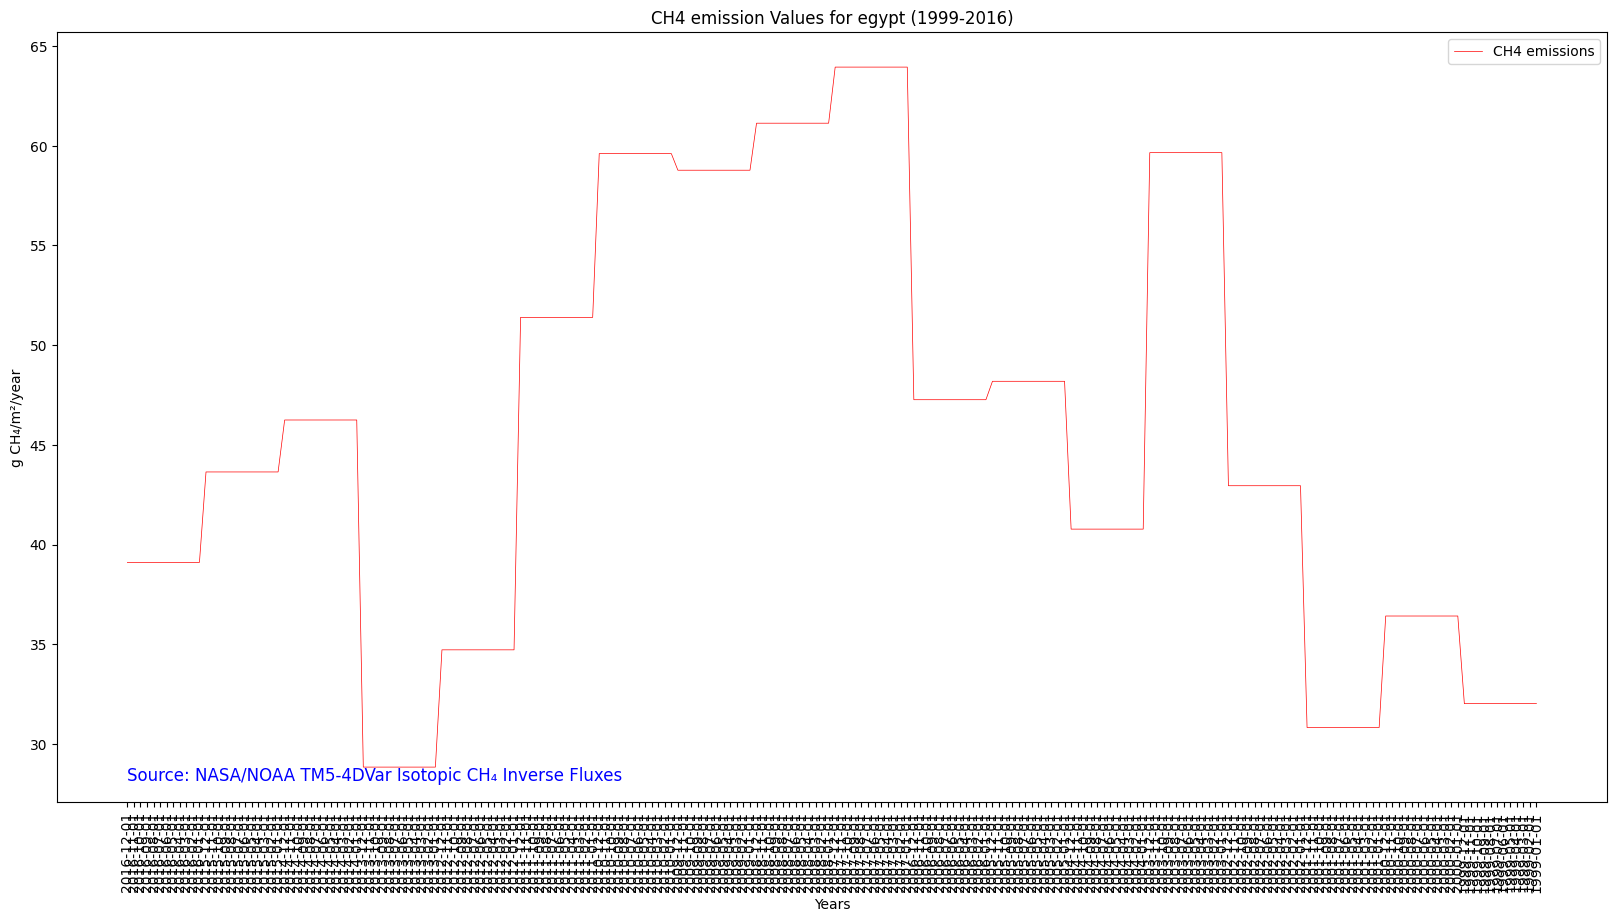

In [56]:
fig = plt.figure(figsize=(20, 10))

plt.plot(
    df["datetime"], 
    df["max"], 
    color="red",
    linestyle="-",
    linewidth=0.5, 
    label="CH4 emissions", 
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("g CH₄/m²/year")
plt.xticks(rotation = 90)
plt.title("CH4 emission Values for egypt (1999-2016)")

plt.text(
    df["datetime"].iloc[0],           
    df["max"].min(),                  

    "Source: NASA/NOAA TM5-4DVar Isotopic CH₄ Inverse Fluxes",                  
    fontsize=12,                             
    horizontalalignment="left",              
    verticalalignment="top",                 
    color="blue")                         

plt.show()

In [57]:
import pandas as pd

# Perform one-hot encoding on the 'start_datetime' column
df_encoded_fixed = pd.get_dummies(df, columns=['datetime'])

# Inspect the data types of the dataframe to identify non-boolean columns
print(df_encoded_fixed.dtypes)

# Convert only boolean columns (True/False) to integers (1/0)
boolean_columns = df_encoded_fixed.select_dtypes(include=['bool']).columns
df_encoded_fixed[boolean_columns] = df_encoded_fixed[boolean_columns].astype(int)

# Display the result
df_encoded_fixed


min                    float64
max                    float64
mean                   float64
count                  float64
sum                    float64
                        ...   
datetime_2016-08-01       bool
datetime_2016-09-01       bool
datetime_2016-10-01       bool
datetime_2016-11-01       bool
datetime_2016-12-01       bool
Length: 233, dtype: object


,min,max,mean,count,sum,std,median,majority,minority,unique,...,datetime_2016-03-01,datetime_2016-04-01,datetime_2016-05-01,datetime_2016-06-01,datetime_2016-07-01,datetime_2016-08-01,datetime_2016-09-01,datetime_2016-10-01,datetime_2016-11-01,datetime_2016-12-01
0,1.061824e-06,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,1.061824e-06,1.061824e-06,90.0,...,0,0,0,0,0,0,0,0,0,1
1,1.061824e-06,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,1.061824e-06,1.061824e-06,90.0,...,0,0,0,0,0,0,0,0,1,0
2,1.061824e-06,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,1.061824e-06,1.061824e-06,90.0,...,0,0,0,0,0,0,0,1,0,0
3,1.061824e-06,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,1.061824e-06,1.061824e-06,90.0,...,0,0,0,0,0,0,1,0,0,0
4,1.061824e-06,39.108028,2.167592,90.0,195.083264,6.446467,0.006415,1.061824e-06,1.061824e-06,90.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,4.879321e-07,32.021940,1.454727,90.0,130.925412,5.274217,0.002519,4.879321e-07,4.879321e-07,90.0,...,0,0,0,0,0,0,0,0,0,0
212,4.879321e-07,32.021940,1.454727,90.0,130.925412,5.274217,0.002519,4.879321e-07,4.879321e-07,90.0,...,0,0,0,0,0,0,0,0,0,0
213,4.879321e-07,32.021940,1.454727,90.0,130.925412,5.274217,0.002519,4.879321e-07,4.879321e-07,90.0,...,0,0,0,0,0,0,0,0,0,0
214,4.879321e-07,32.021940,1.454727,90.0,130.925412,5.274217,0.002519,4.879321e-07,4.879321e-07,90.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
print(df_encoded_fixed.columns)


Index(['min', 'max', 'mean', 'count', 'sum', 'std', 'median', 'majority',
       'minority', 'unique',
       ...
       'datetime_2016-03-01', 'datetime_2016-04-01', 'datetime_2016-05-01',
       'datetime_2016-06-01', 'datetime_2016-07-01', 'datetime_2016-08-01',
       'datetime_2016-09-01', 'datetime_2016-10-01', 'datetime_2016-11-01',
       'datetime_2016-12-01'],
      dtype='object', length=233)


In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Drop 'max' column from features if it exists
X = df_encoded_fixed.drop(columns=['max'], errors='ignore')  # Dropping 'max' from features

# Select only numeric columns for features
X = X.select_dtypes(include=[np.number])  # Ensure only numeric data is selected
y = df_encoded_fixed['max']  # Assuming 'max' is the target column

# Check if there are any problematic data types
print(X.dtypes)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target separately
X_scaled = scaler_X.fit_transform(X)  # Scale features
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Scale target (reshape required for MinMaxScaler)

# Reshape X for LSTM (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Output the shapes to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



min                    float64
mean                   float64
count                  float64
sum                    float64
std                    float64
                        ...   
datetime_2016-08-01      int32
datetime_2016-09-01      int32
datetime_2016-10-01      int32
datetime_2016-11-01      int32
datetime_2016-12-01      int32
Length: 230, dtype: object
X_train shape: (172, 1, 230)
X_test shape: (44, 1, 230)
y_train shape: (172, 1)
y_test shape: (44, 1)


In [61]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()

# Add the LSTM layer (input shape: timesteps=1, features=X_train.shape[2])
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add the output layer (Dense layer with one output neuron for regression)
model.add(Dense(1))

# Compile the model (using mean squared error loss for regression)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Print the model summary
model.summary()


# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)



c:\Users\zahra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        56,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,251 (219.73 KB)

 Trainable params: 56,251 (219.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.3648 - val_loss: 0.3366
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2273 - val_loss: 0.2396
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1748 - val_loss: 0.1606
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1119 - val_loss: 0.0997
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0738 - val_loss: 0.0567
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0358 - val_loss: 0.0322
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0254 - val_loss: 0.0214
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0245 - val_loss: 0.0181
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0227 - val_loss: 0.0172
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0233 - val_loss: 0.0167
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189 - val_loss: 0.0168
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - val_loss: 0.0173


In [62]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values (if scaled)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Print some sample predictions vs actual values
for i in range(5):
    print(f"Predicted: {y_pred_rescaled[i][0]}, Actual: {y_test_rescaled[i][0]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 
Test Loss: 0.006582783535122871
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step
Predicted: 35.44545364379883, Actual: 36.41712360748333
Predicted: 33.03255844116211, Actual: 32.02194038501322
Predicted: 46.399375915527344, Actual: 48.189216163271695
Predicted: 40.354820251464844, Actual: 42.951508269989496
Predicted: 46.39653778076172, Actual: 43.642343760462374


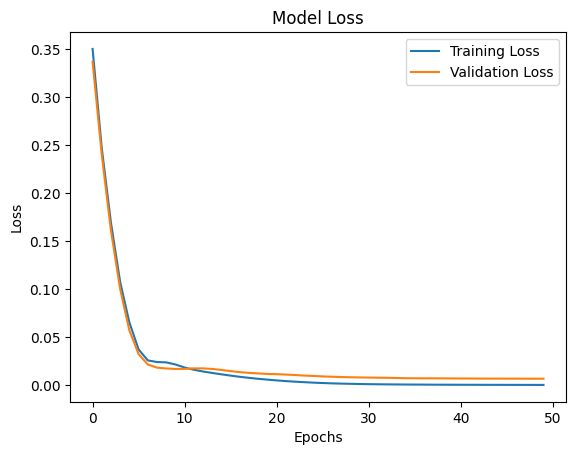

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [65]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np

# Assuming you have y_test_rescaled and y_pred_rescaled as your model predictions and actual values
# Example data: Replace with your actual data
epochs = np.arange(1, 101)
train_loss = np.random.rand(100)
val_loss = np.random.rand(100)
y_test_rescaled = np.random.rand(50) * 100
y_pred_rescaled = np.random.rand(50) * 100

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("LSTM Model Dashboard"),
    
    # First graph: Training and Validation Loss over Epochs
    dcc.Graph(id='loss-graph'),
    
    # Second graph: Predicted vs Actual values
    dcc.Graph(id='pred-actual-graph'),
    
    # Dropdown for selecting the number of epochs (for interactivity)
    dcc.Slider(
        id='epoch-slider',
        min=1,
        max=100,
        step=1,
        value=50,
        marks={str(epoch): str(epoch) for epoch in range(1, 101, 10)},
    ),
])

# Update the Loss graph based on the number of epochs selected by the slider
@app.callback(
    Output('loss-graph', 'figure'),
    [Input('epoch-slider', 'value')]
)
def update_loss_graph(selected_epoch):
    # Slice the loss data based on selected epoch
    trace1 = go.Scatter(x=epochs[:selected_epoch], y=train_loss[:selected_epoch], mode='lines', name='Train Loss')
    trace2 = go.Scatter(x=epochs[:selected_epoch], y=val_loss[:selected_epoch], mode='lines', name='Validation Loss')
    
    return {
        'data': [trace1, trace2],
        'layout': go.Layout(title='Training and Validation Loss',
                            xaxis={'title': 'Epochs'},
                            yaxis={'title': 'Loss'})
    }

# Update the Predictions vs Actual graph
@app.callback(
    Output('pred-actual-graph', 'figure'),
    [Input('epoch-slider', 'value')]
)
def update_pred_actual_graph(selected_epoch):
    # This graph doesn't depend on epoch, but you could add interactivity here if needed
    trace1 = go.Scatter(x=y_test_rescaled, y=y_pred_rescaled, mode='markers', name='Predictions vs Actual')
    
    return {
        'data': [trace1],
        'layout': go.Layout(title='Predictions vs Actual',
                            xaxis={'title': 'Actual Values'},
                            yaxis={'title': 'Predicted Values'},
                            showlegend=True)
    }

if __name__ == "__main__":
    app.run_server(debug=True, port=8057)  # Change to a different port (e.g., 8057)


